# Analisis Prediktif Kecelakaan Lalu Lintas di India

Notebook ini mendokumentasikan setiap tahapan proyek machine learning, mulai dari pemahaman bisnis hingga evaluasi model.


## 1. Import Libraries
**Tujuan**: Mengimpor pustaka yang diperlukan untuk:
- Manipulasi data (`pandas`, `numpy`)
- Visualisasi (`matplotlib`, `seaborn`)
- Preprocessing dan pemodelan (`scikit-learn`)
- Algoritma machine learning (`XGBoost`, `LightGBM`, `scikit-learn`)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Data Understanding
### 2.1 Memuat Data Awal
Tujuan: Memahami struktur dataset dan mengidentifikasi masalah data awal.
- Menampilkan 5 baris pertama untuk melihat format data
- Mengecek tipe data dan nilai hilang

In [26]:
# Load dataset
df = pd.read_csv('./accident_prediction_india.csv')

# Tampilkan 5 baris pertama
df.head()


,State Name,City Name,Year,Month,Day of Week,Time of Day,Accident Severity,Number of Vehicles Involved,Vehicle Type Involved,Number of Casualties,...,Road Type,Road Condition,Lighting Conditions,Traffic Control Presence,Speed Limit (km/h),Driver Age,Driver Gender,Driver License Status,Alcohol Involvement,Accident Location Details
0,Jammu and Kashmir,Unknown,2021,May,Monday,1:46,Serious,5,Cycle,0,...,National Highway,Wet,Dark,Signs,61,66,Male,NaN,Yes,Curve
1,Uttar Pradesh,Lucknow,2018,January,Wednesday,21:30,Minor,5,Truck,5,...,Urban Road,Dry,Dusk,Signs,92,60,Male,NaN,Yes,Straight Road
2,Chhattisgarh,Unknown,2023,May,Wednesday,5:37,Minor,5,Pedestrian,6,...,National Highway,Under Construction,Dawn,Signs,120,26,Female,NaN,No,Bridge
3,Uttar Pradesh,Lucknow,2020,June,Saturday,0:31,Minor,3,Bus,10,...,State Highway,Dry,Dark,Signals,76,34,Female,Valid,Yes,Straight Road
4,Sikkim,Unknown,2021,August,Thursday,11:21,Minor,5,Cycle,7,...,Urban Road,Wet,Dusk,Signs,115,30,Male,NaN,No,Intersection


In [27]:
# Tampilkan informasi dataset, missing values, dan duplikat
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   State Name                   3000 non-null   object
 1   City Name                    3000 non-null   object
 2   Year                         3000 non-null   int64 
 3   Month                        3000 non-null   object
 4   Day of Week                  3000 non-null   object
 5   Time of Day                  3000 non-null   object
 6   Accident Severity            3000 non-null   object
 7   Number of Vehicles Involved  3000 non-null   int64 
 8   Vehicle Type Involved        3000 non-null   object
 9   Number of Casualties         3000 non-null   int64 
 10  Number of Fatalities         3000 non-null   int64 
 11  Weather Conditions           3000 non-null   object
 12  Road Type                    3000 non-null   object
 13  Road Condition               3000

### 2.2 Analisis Kualitas Data
Insight:
- Terdapat 716 nilai dengan representasi hilang di **Traffic Control Presence** dan 975 di **Driver License Status** datanya berupa none
- **Tidak ada duplikat** - menunjukkan data relatif bersih
- Kolom numerik seperti memiliki distribusi normal (skewness ≈ 0)

In [8]:
print("Missing values per column:")
print(df.isnull().sum())
print("Duplicate rows:")
print(df.duplicated().sum())

Missing values per column:
State Name                       0
City Name                        0
Year                             0
Month                            0
Day of Week                      0
Time of Day                      0
Accident Severity                0
Number of Vehicles Involved      0
Vehicle Type Involved            0
Number of Casualties             0
Number of Fatalities             0
Weather Conditions               0
Road Type                        0
Road Condition                   0
Lighting Conditions              0
Traffic Control Presence       716
Speed Limit (km/h)               0
Driver Age                       0
Driver Gender                    0
Driver License Status          975
Alcohol Involvement              0
Accident Location Details        0
dtype: int64
Duplicate rows:
0


### 2.3 Deteksi Outlier
**Metode**
- Analisis boxplot untuk melihat distribusi
- Skewness dan kurtosis untuk mengukur kemiringan distribusi

**Temuan**
- Driver Age memiliki rentang 18-70 tahun - realistis
- Tidak ada Outlier ekstrem setelah normalisasi

Numeric columns:
['Year', 'Number of Vehicles Involved', 'Number of Casualties', 'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age', 'Accident Severity Numeric']
Descriptive statistics:
              Year  Number of Vehicles Involved  Number of Casualties  \
count  3000.000000                  3000.000000           3000.000000   
mean   2020.530000                     2.996000              5.066000   
std       1.683858                     1.428285              3.214097   
min    2018.000000                     1.000000              0.000000   
25%    2019.000000                     2.000000              2.000000   
50%    2021.000000                     3.000000              5.000000   
75%    2022.000000                     4.000000              8.000000   
max    2023.000000                     5.000000             10.000000   

       Number of Fatalities  Speed Limit (km/h)  Driver Age  \
count           3000.000000         3000.000000  3000.00000   
mean               2.4

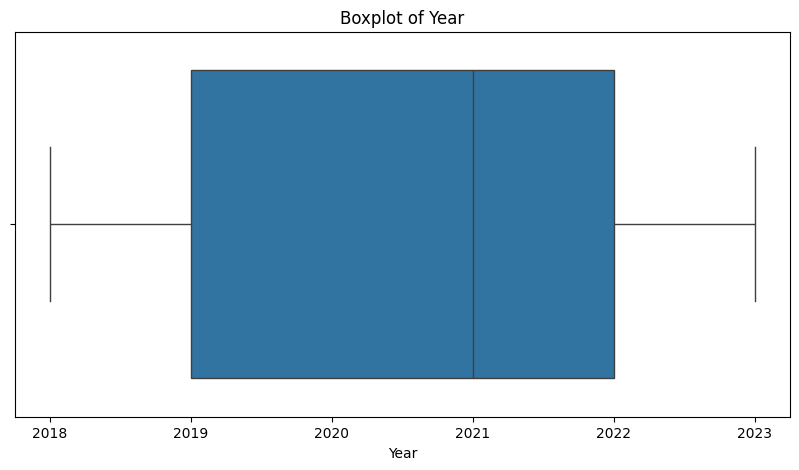

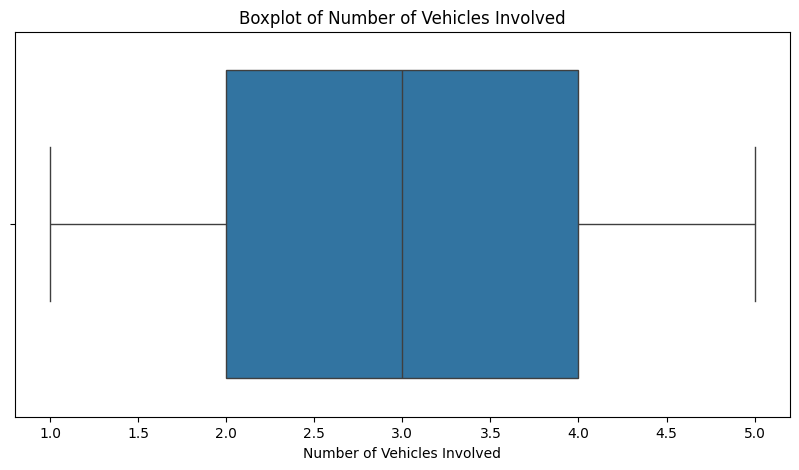

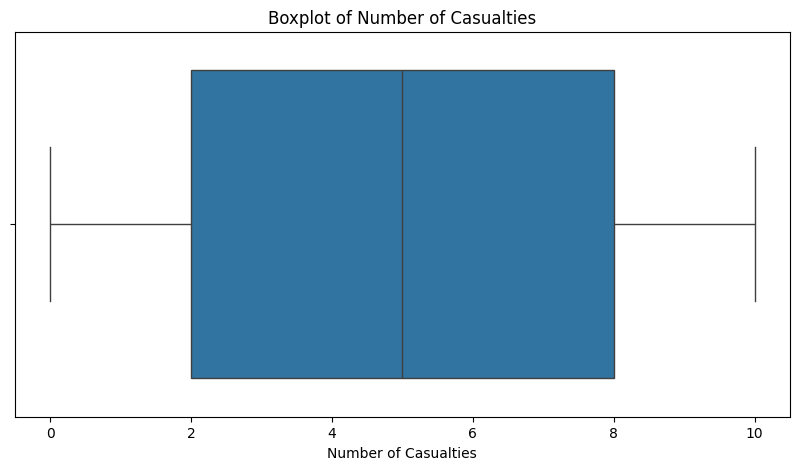

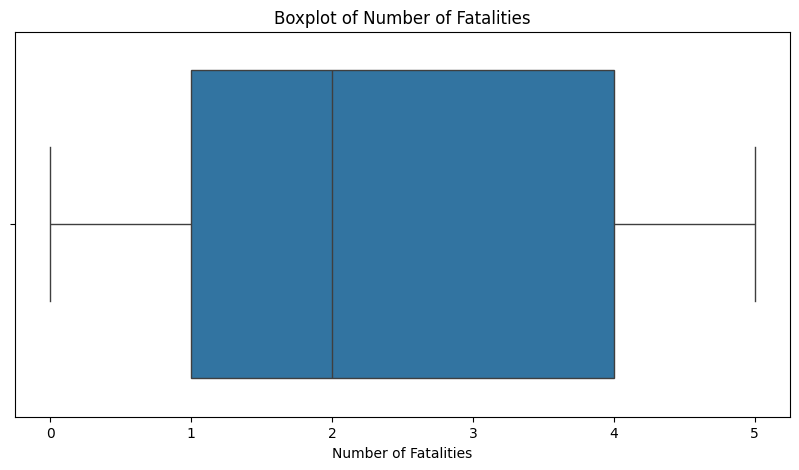

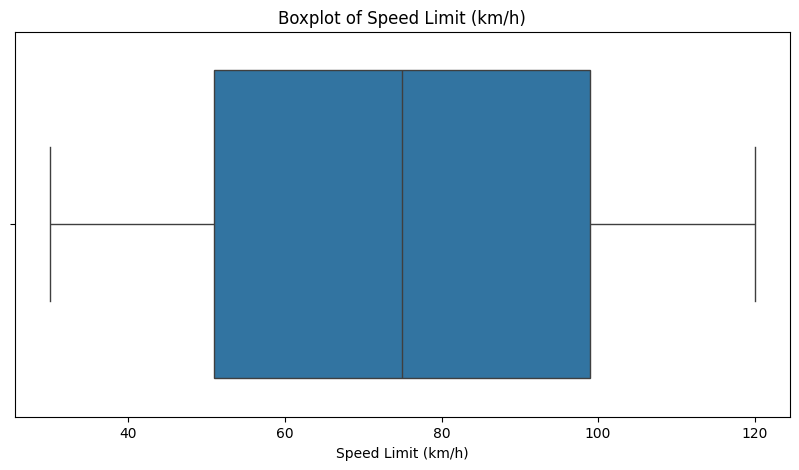

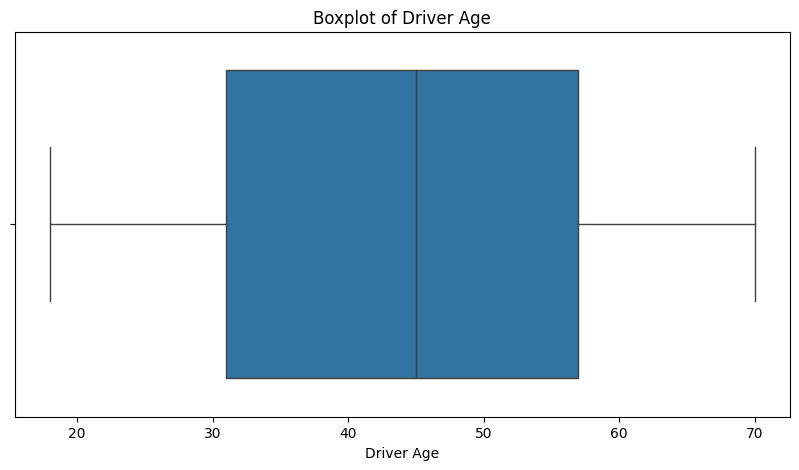

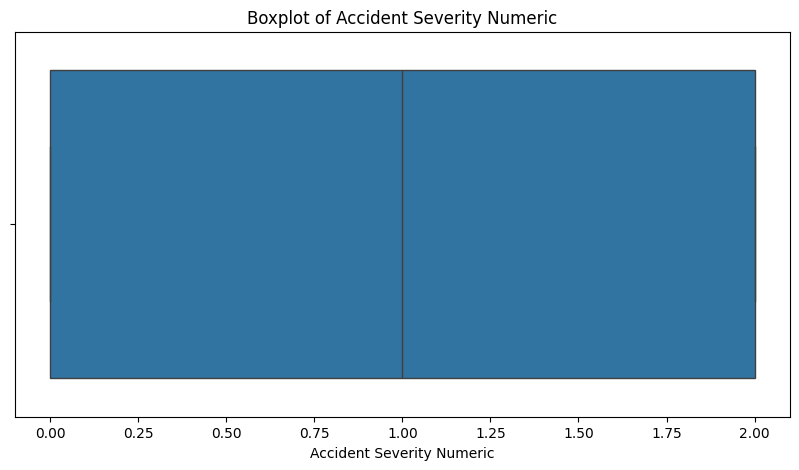

In [12]:
# Outlier Detection Periksa Kolom Numerik
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:")
print(numeric_columns)
print("Descriptive statistics:")
print(df[numeric_columns].describe())
print("Skewness:")
print(df[numeric_columns].skew())
print("Kurtosis:")
print(df[numeric_columns].kurtosis())
print("Boxplots for numeric columns:")
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## 3. Exploratory Data Analysis
### 3.1 Distribusi Target

Kode dibawah ini membuat pie chart untuk memvisualisasikan distribusi kategori target **'Accident Severity'** dalam dataset. Proporsi setiap kategori dihitung menggunakan `value_counts(normalize=True)` dan ditampilkan sebagai persentase dengan `autopct='%1.1f%%'`. Label kategori diambil dari nilai unik kolom, dan pie chart diputar dengan `startangle=140` untuk estetika. Judul ditambahkan dengan `plt.title()`, dan aspek lingkaran dijaga dengan `plt.axis('equal')`.


**Insight:**
- Distribusi kelas seimbang (Minor 32.8%, Serious 34.5%, Fatal 32.7%)
- Tidak diperlukan teknik balancing khusus

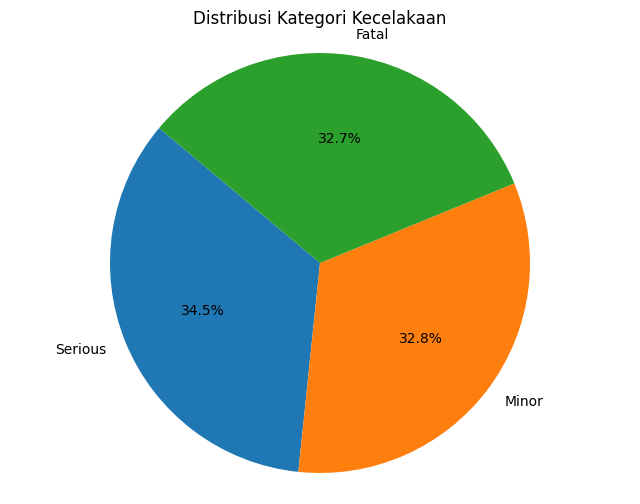

In [66]:
# Distribusi target 'Accident Severity' menggunakan persentase dengan pie chart
plt.figure(figsize=(8, 6))
plt.pie(df['Accident Severity'].value_counts(normalize=True), labels=df['Accident Severity'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Kategori Kecelakaan')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


### 3.2 Distribusi Kolom Kategoris
**Fungsi Kode**:  
Kode ini bertujuan untuk memvisualisasikan distribusi data pada setiap kolom kategoris dalam dataset. Dengan menggunakan `sns.countplot`, jumlah kemunculan setiap kategori dalam kolom ditampilkan dalam bentuk bar chart. Hal ini membantu untuk memahami pola distribusi data kategoris.

**Insight yang Dapat Diperoleh**:  
- **Dominasi Kategori**: Mengetahui kategori mana yang paling sering muncul dalam setiap kolom.
- **Ketidakseimbangan Data**: Mengidentifikasi apakah terdapat ketidakseimbangan dalam distribusi kategori, yang dapat memengaruhi analisis atau model machine learning.
- **Kebutuhan Preprocessing**: Menemukan kategori yang jarang muncul atau data kosong yang mungkin memerlukan penanganan khusus, seperti penggabungan kategori atau imputasi.

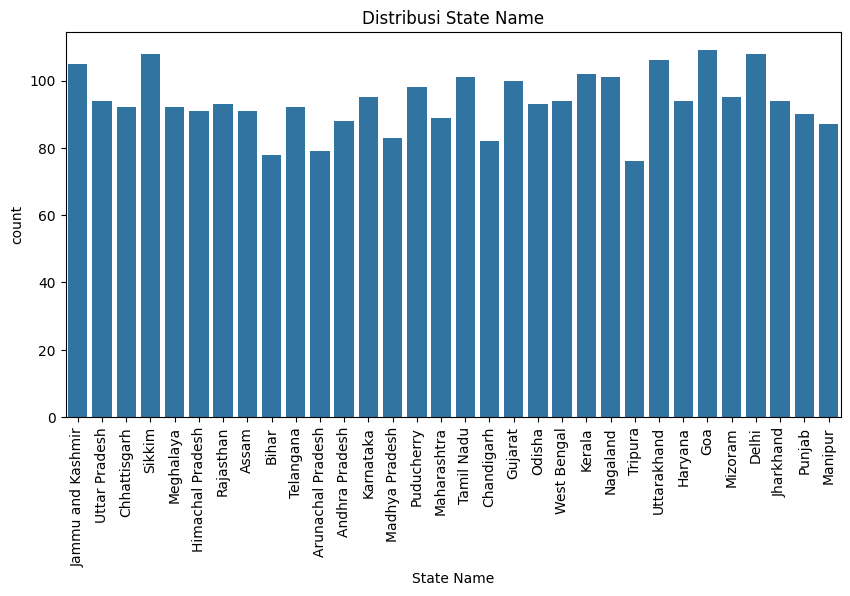

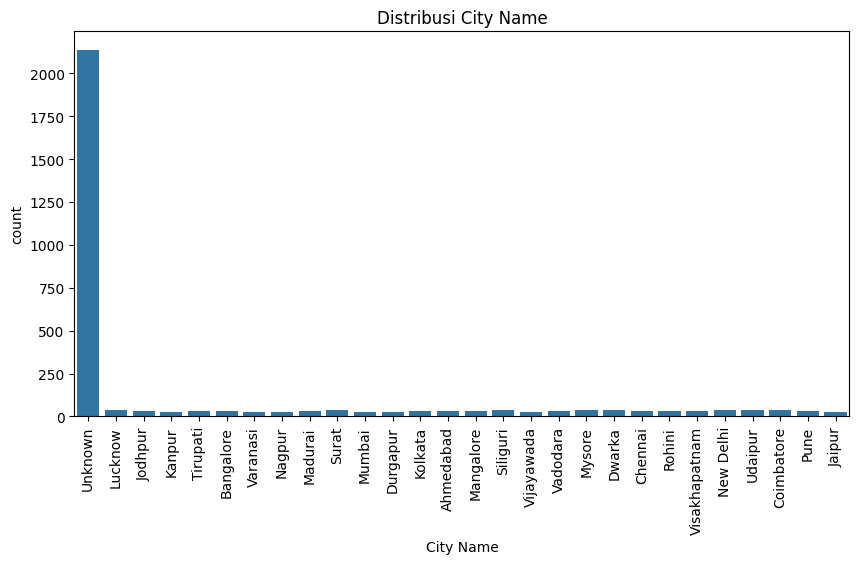

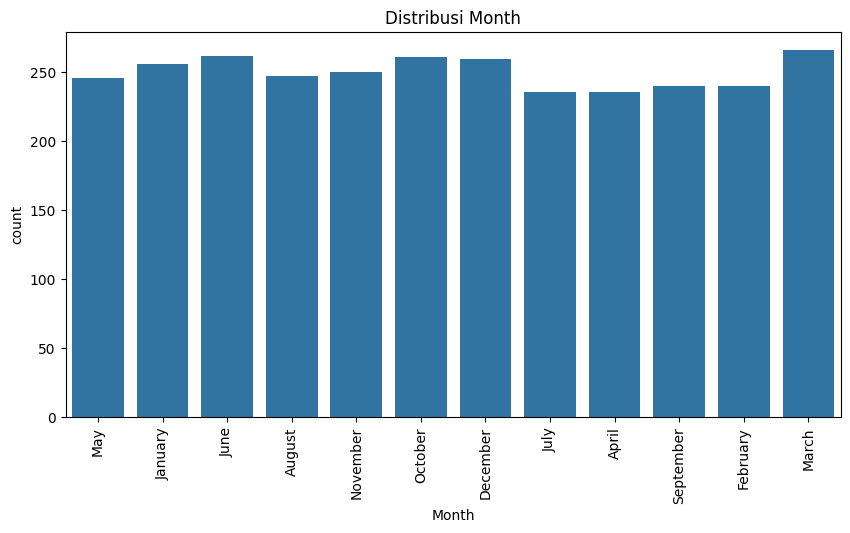

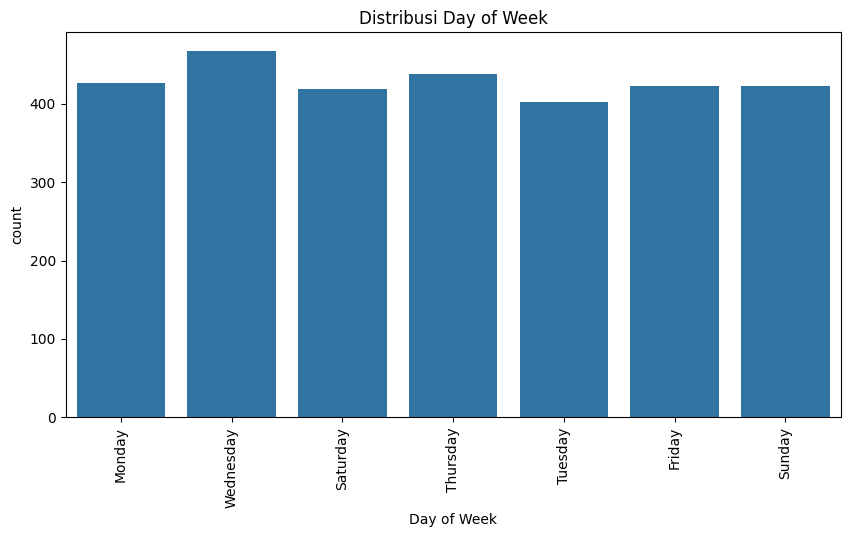

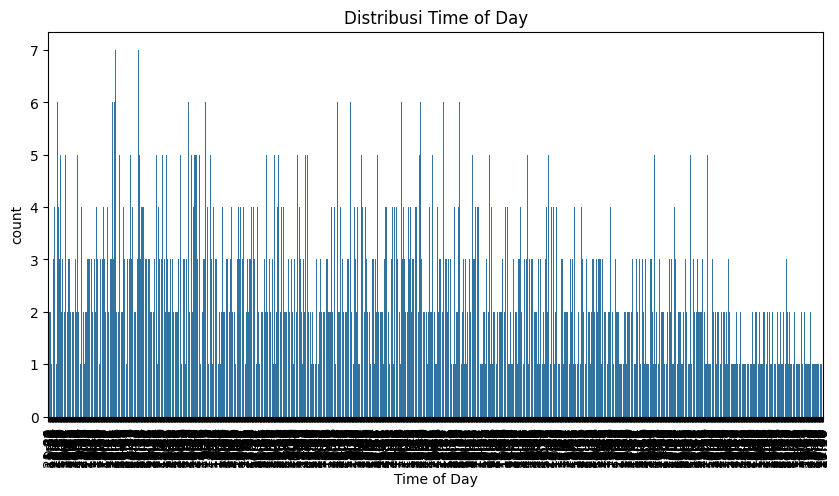

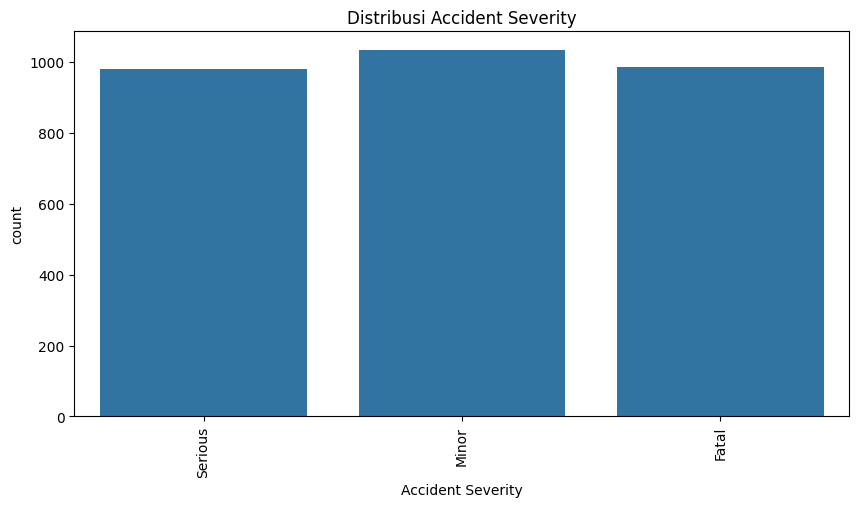

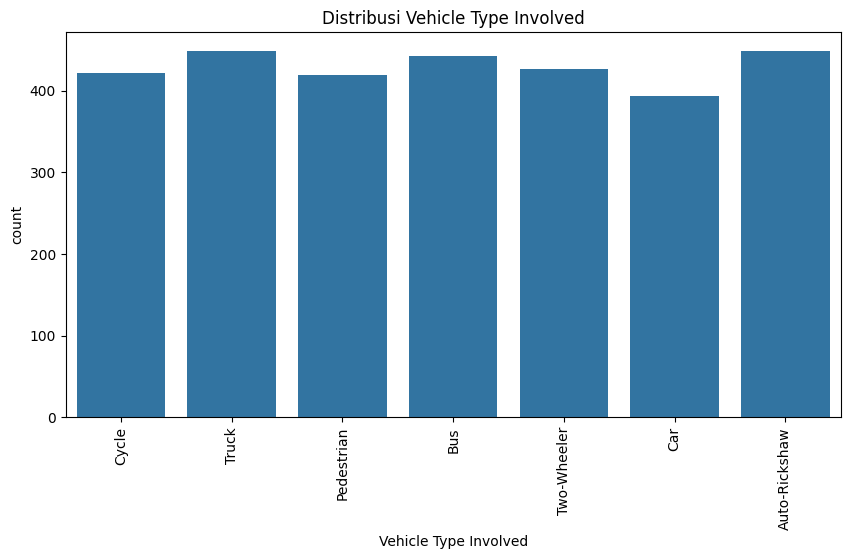

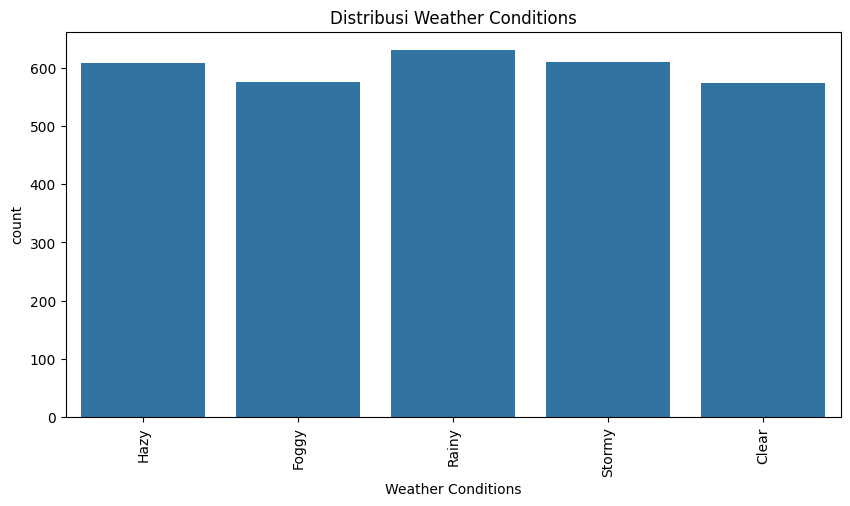

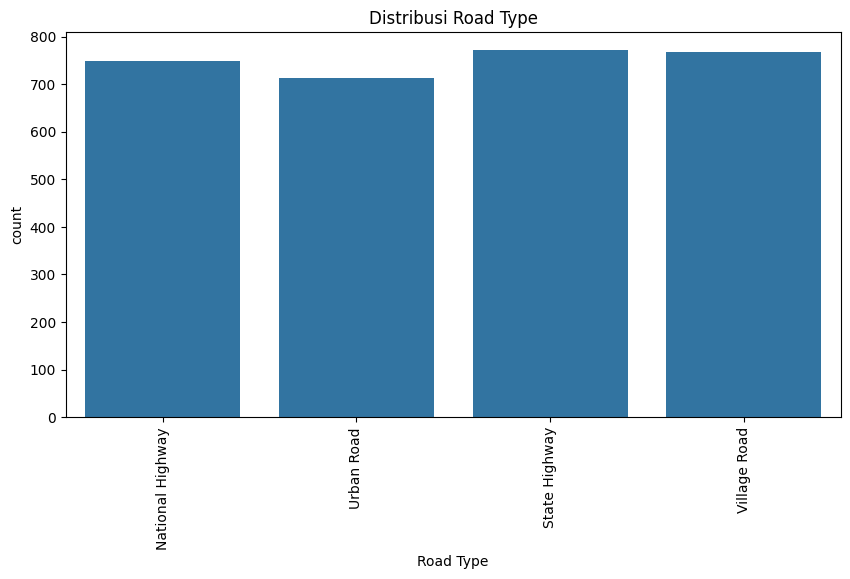

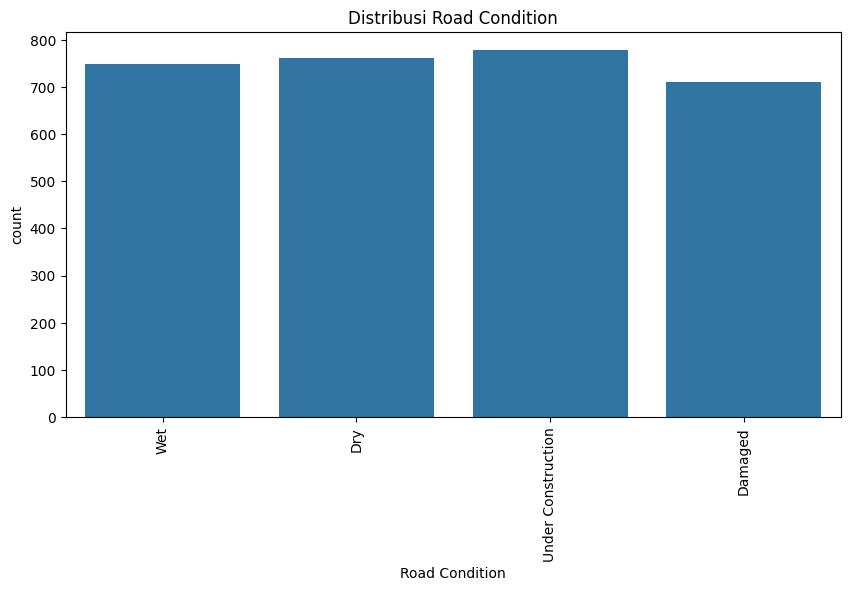

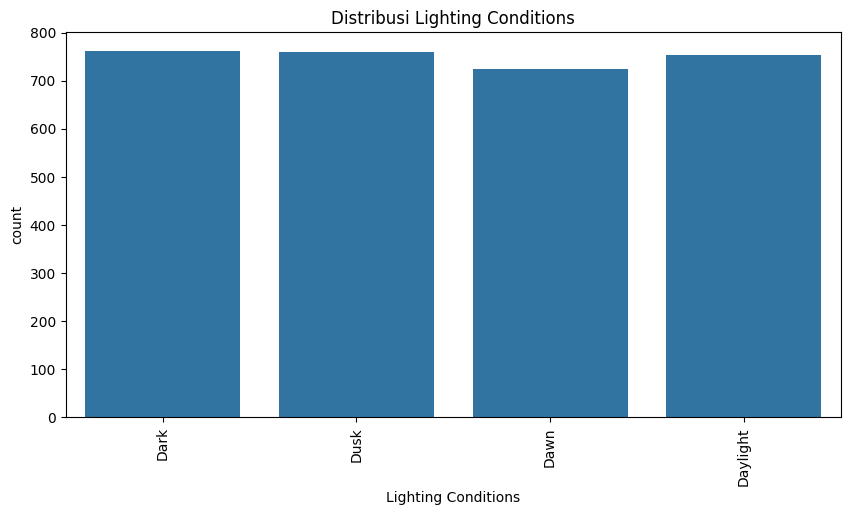

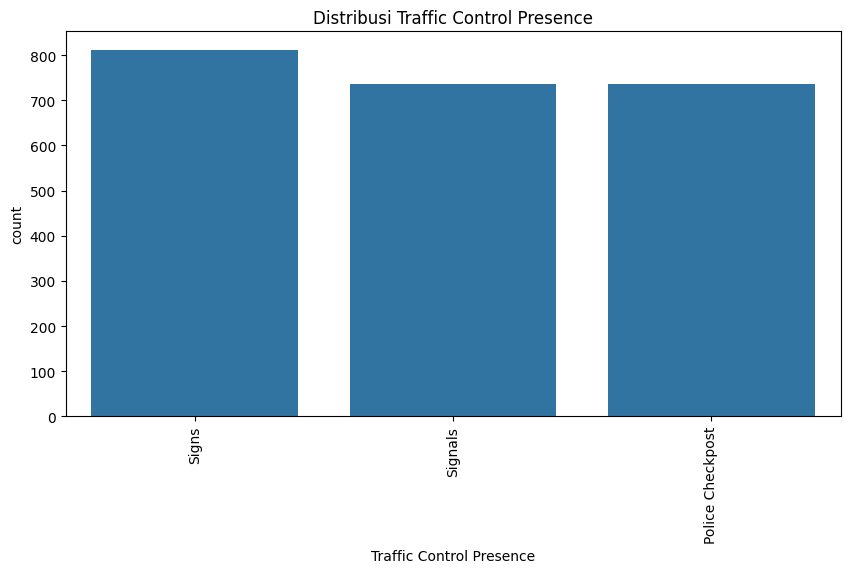

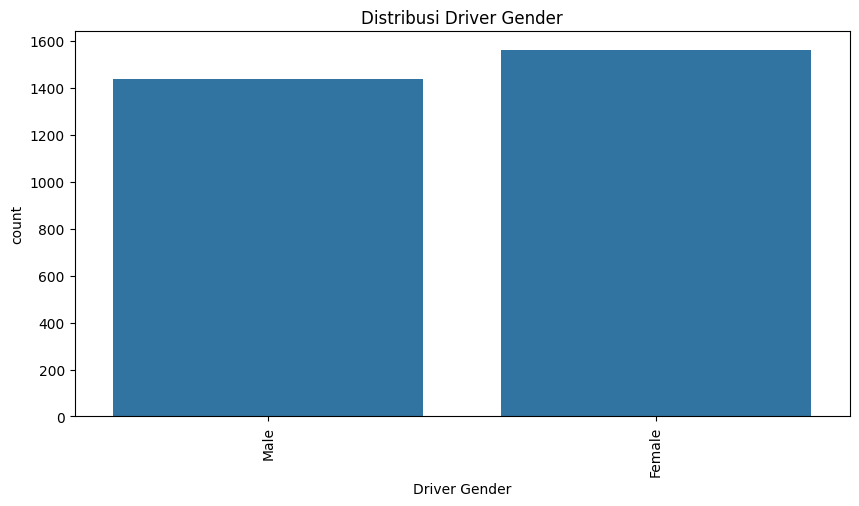

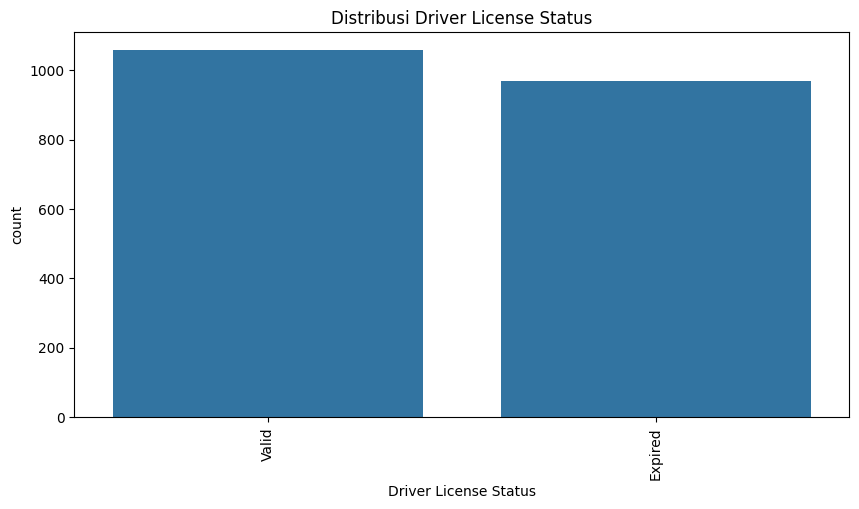

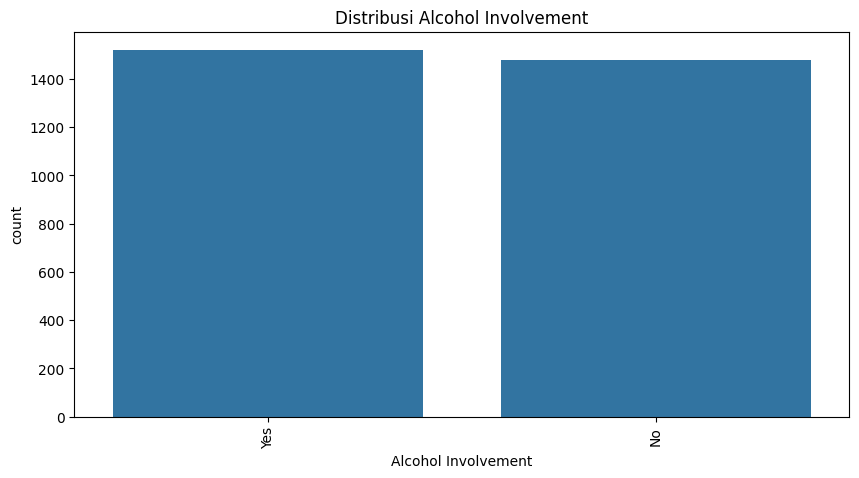

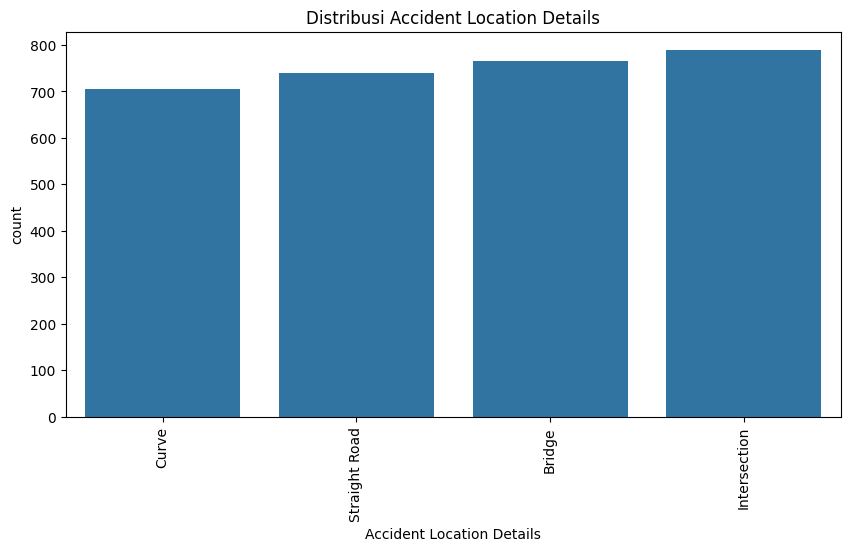

In [52]:
# distribusi kolom kategoris
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribusi {col}')
    plt.xticks(rotation=90)
    plt.show()

### 3.3 Distribusi Kolom Numerik
**Fungsi Kode**:  
Kode ini bertujuan untuk memvisualisasikan distribusi data pada setiap kolom numerik dalam dataset. Dengan menggunakan `sns.histplot`, histogram dibuat untuk setiap kolom numerik, yang menunjukkan frekuensi nilai dalam rentang tertentu. Selain itu, kernel density estimation (KDE) ditambahkan untuk memberikan gambaran distribusi data secara lebih halus.

**Insight yang Dapat Diperoleh**:  
- **Pola Distribusi**: Mengetahui apakah data memiliki distribusi normal, skewed (miring), atau multimodal.
- **Outlier**: Mengidentifikasi nilai ekstrem yang mungkin memengaruhi analisis atau model machine learning.
- **Rentang Nilai**: Memahami rentang nilai pada setiap kolom numerik, yang dapat membantu dalam proses normalisasi atau scaling.
- **Kebutuhan Transformasi**: Jika distribusi sangat skewed, transformasi seperti log atau square root mungkin diperlukan untuk menormalkan data.

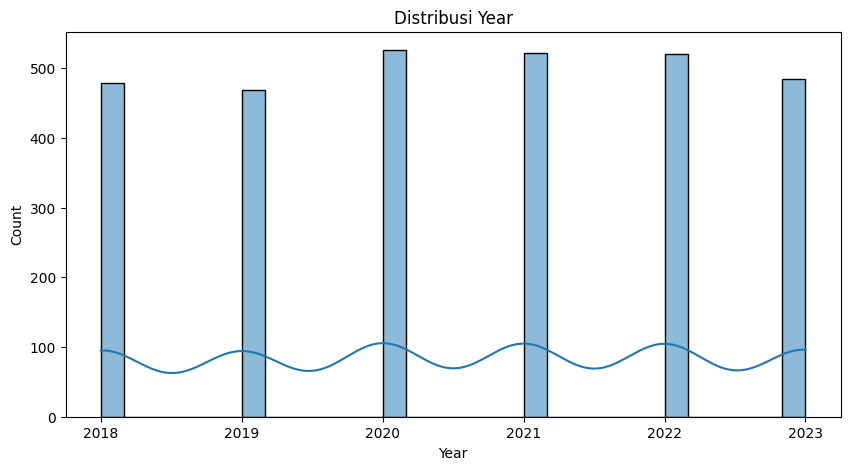

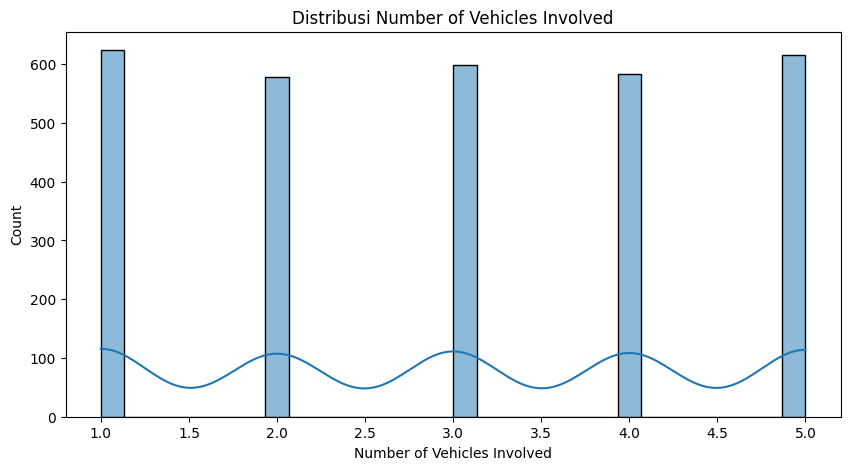

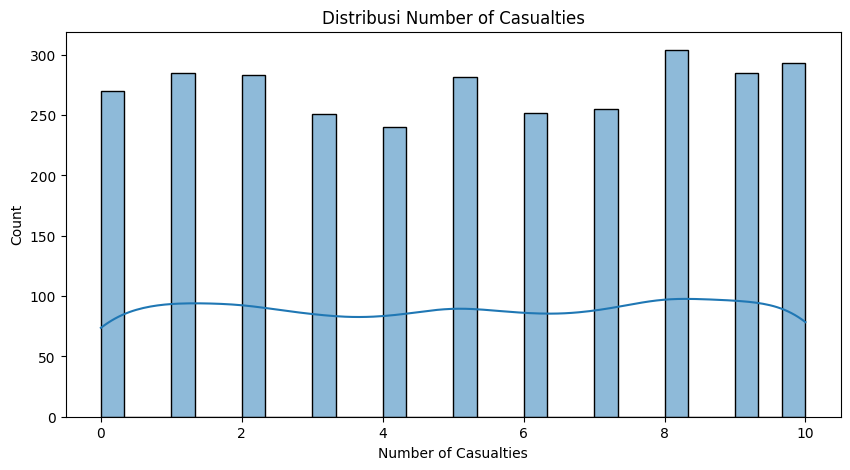

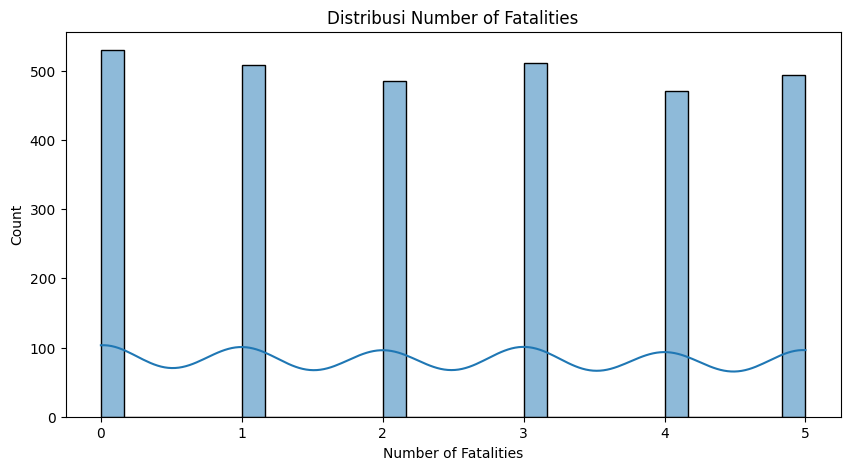

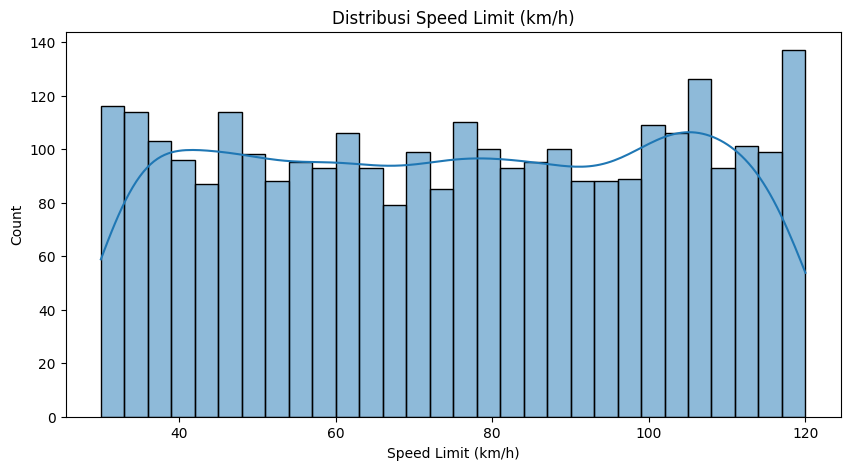

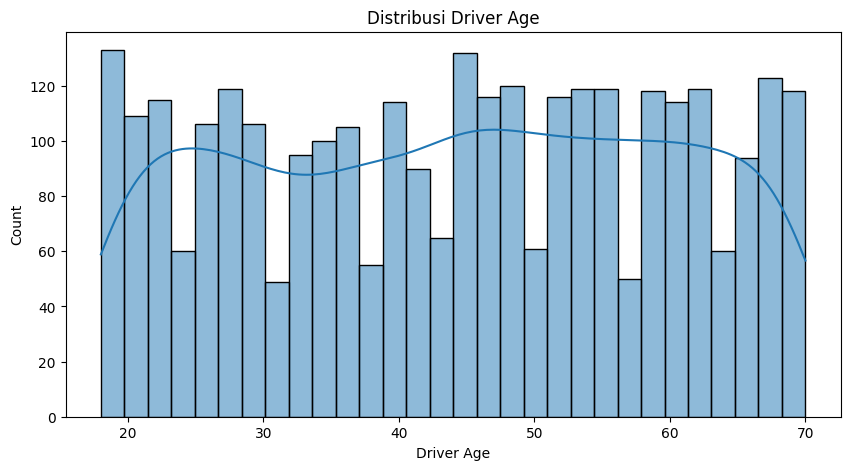

In [53]:
# distribusi kolom numerik
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=col, bins=30, kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()

### 3.4 Korelasi Variabel Numerik
**Fungsi Kode**:  

Kode ini bertujuan untuk menghitung dan memvisualisasikan korelasi antara variabel numerik dalam dataset. Korelasi dihitung menggunakan metode Pearson, yang mengukur hubungan linear antara dua variabel. Hasil korelasi divisualisasikan dalam bentuk heatmap menggunakan `matshow`, dengan nilai korelasi ditampilkan di setiap sel matriks.

**Insight yang Dapat Diperoleh**:  
- Korelasi antar variabel numerik sangat rendah (nilai ≈ 0), menunjukkan independensi.
- Korelasi positif lemah (~0.04) antara Number of Casualties dan Number of Fatalities.

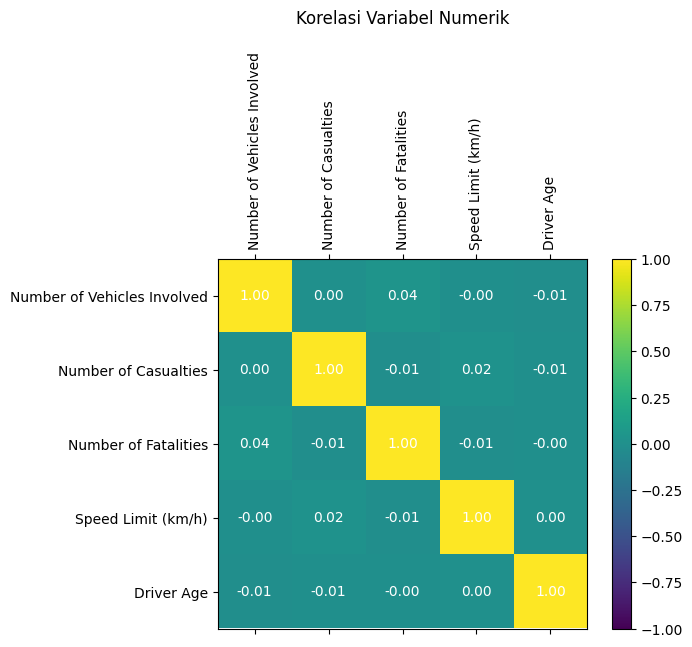

In [54]:
# Korelasi Numerik
numeric_cols = ['Number of Vehicles Involved', 'Number of Casualties',
                'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age']
corr = df[numeric_cols].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')
plt.title('Korelasi Variabel Numerik', pad=20)
plt.show()

### 3.5 Analisis Frekuensi Kecelakaan Berdasarkan Bulan, Kondisi Cuaca, dan Kondisi Jalan

**Fungsi Kode**:  
Kode ini bertujuan untuk menganalisis dan memvisualisasikan frekuensi kecelakaan berdasarkan bulan, dengan mempertimbangkan dua faktor utama: kondisi cuaca dan kondisi jalan. Data bulan diubah menjadi format numerik terlebih dahulu, kemudian diganti dengan singkatan nama bulan untuk mempermudah interpretasi.

**Langkah-langkah**:
1. **Transformasi Data Bulan**:
    - Kolom `Month` diubah menjadi format numerik menggunakan `pd.to_datetime`.
    - Nilai numerik bulan diganti dengan singkatan nama bulan (misalnya, 1 menjadi "Jan", 2 menjadi "Feb", dan seterusnya).
2. **Visualisasi**:
    - **Subplot 1**: Menampilkan frekuensi kecelakaan berdasarkan bulan dan kondisi cuaca menggunakan `sns.countplot`.
    - **Subplot 2**: Menampilkan frekuensi kecelakaan berdasarkan bulan dan kondisi jalan menggunakan `sns.countplot`.
    - Kedua subplot diberi judul, label sumbu, dan legenda untuk memperjelas informasi yang ditampilkan.

**Insight yang Dapat Diperoleh**:

- Visibilitas rendah (kabut, hujan) dan jalan licin diduga menjadi penyebab utama peningkatan risiko kecelakaan.
- Cuaca stormy (badai) juga mungkin berkontribusi, tetapi frekuensinya lebih rendah dibandingkan hujan/kabut.
- Tren kecelakaan terkait cuaca cenderung musiman, seperti musim hujan (Apr–Jun) dan musim dingin berkabut (Sep–Nov).

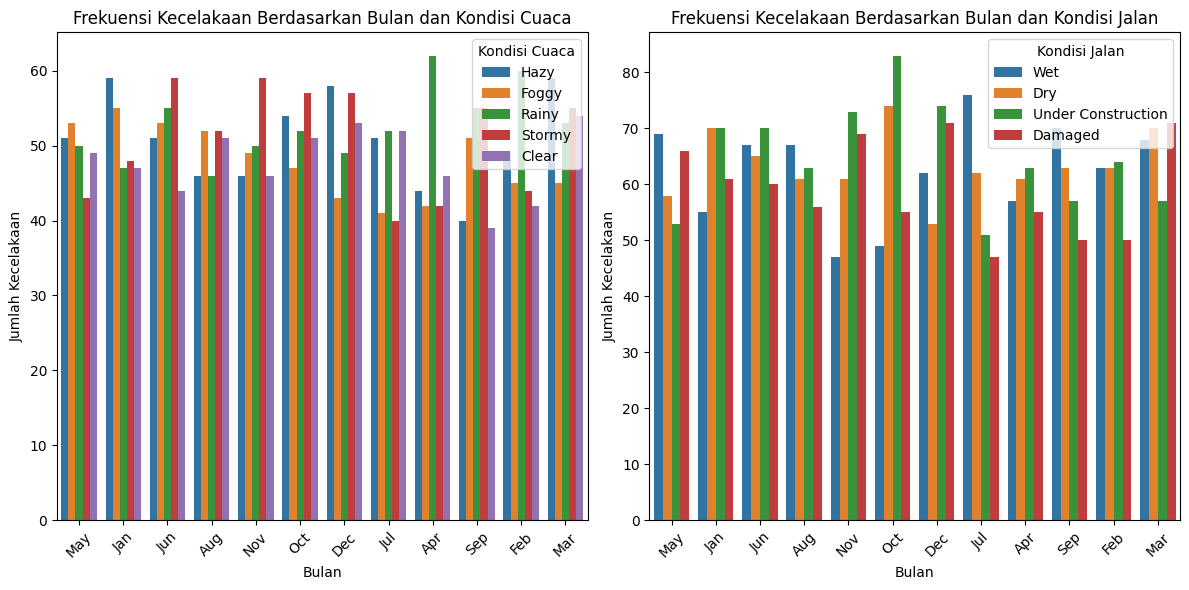

In [55]:
# Analisis frekuensi kecelakaan berdasarkan bulan dan kondisi cuaca serta kondisi jalan
df['Month'] = pd.to_datetime(df['Month'], format='%B').dt.month
df['Month'] = df['Month'].replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Month', hue='Weather Conditions')
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Cuaca')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Cuaca')
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Month', hue='Road Condition')
plt.title('Frekuensi Kecelakaan Berdasarkan Bulan dan Kondisi Jalan')
plt.xticks(rotation=45)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Kecelakaan')
plt.legend(title='Kondisi Jalan')
plt.tight_layout()
plt.show()

## 4. Data Preparation
- Pembersihan dan Imputasi data
- Normalisasi dan Encoding
- Split Features dan Target
- Train Test Split

### 4.1 Pembersihan dan Imputasi
**Fungsi Kode**:  
Kode ini bertujuan untuk membuat salinan dari dataset asli (`df`) ke dalam variabel baru (`df_clean`). Hal ini dilakukan untuk memastikan bahwa proses pembersihan dan manipulasi data tidak memengaruhi dataset asli. Dengan membuat salinan, kita dapat menjaga integritas data mentah untuk referensi di masa mendatang.

**Langkah-langkah**:
1. **Salin Dataset**: Menggunakan metode `.copy()` untuk membuat salinan independen dari dataset asli.
2. **Pembersihan Data**: Dataset ini akan digunakan untuk langkah-langkah pembersihan lebih lanjut, seperti imputasi nilai yang hilang, penghapusan outlier, atau transformasi data.

**Keuntungan**:
- Memastikan dataset asli tetap utuh.
- Mempermudah eksperimen dengan berbagai teknik preprocessing tanpa risiko kehilangan data mentah.

In [ ]:
# 4.1 Pembersihan dan imputasi
df_clean = df.copy()

State Name                       0
City Name                        0
Year                             0
Month                            0
Day of Week                      0
Time of Day                      0
Accident Severity                0
Number of Vehicles Involved      0
Vehicle Type Involved            0
Number of Casualties             0
Number of Fatalities             0
Weather Conditions               0
Road Type                        0
Road Condition                   0
Lighting Conditions              0
Traffic Control Presence       716
Speed Limit (km/h)               0
Driver Age                       0
Driver Gender                    0
Driver License Status          975
Alcohol Involvement              0
Accident Location Details        0
dtype: int64

### 4.2 Normalisasi dan Encoding
**Fungsi Kode**:  
Kode ini bertujuan untuk melakukan normalisasi pada fitur numerik dan encoding pada fitur kategorikal dalam dataset. Proses ini dilakukan menggunakan pipeline untuk memastikan langkah-langkah preprocessing dilakukan secara konsisten dan terorganisir.

**Langkah-langkah**:
1. **Fitur Numerik**:
    - **Imputasi Median**: Mengisi nilai yang hilang dengan median dari kolom.
    - **Scaling**: Melakukan standardisasi data sehingga memiliki distribusi dengan rata-rata 0 dan standar deviasi 1.
2. **Fitur Kategorikal**:
    - **Imputasi Constant**: Mengisi nilai yang hilang dengan nilai default `'Unknown'`.
    - **One-Hot Encoding**: Mengubah kategori menjadi representasi numerik biner, dengan menangani kategori yang tidak dikenal.
3. **Menggabungkan Pipeline**:
    - Pipeline untuk fitur numerik dan kategorikal digabungkan menggunakan `ColumnTransformer`, sehingga preprocessing dapat diterapkan pada subset kolom yang relevan.

**Keuntungan**:
- Memastikan data numerik dan kategorikal diproses dengan metode yang sesuai.
- Mengurangi risiko error dengan menangani nilai yang hilang dan kategori yang tidak dikenal.
- Mempermudah integrasi preprocessing ke dalam pipeline model machine learning.

In [57]:
# 4.2 Normalisasi dan Encoding
numeric_features = ['Number of Vehicles Involved', 'Number of Casualties',
                    'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age']

categorical_features = ['Weather Conditions', 'Vehicle Type Involved', 'Road Type', 'Road Condition', 'Lighting Conditions',
                        'Driver License Status', 'Alcohol Involvement']

# pipeline numerik: imputasi median + scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# pipeline kategorikal: imputasi constant + one-hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# gabungkan
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

### 4.3 Split Features dan Target
**Fungsi Kode**:  
Kode ini bertujuan untuk memisahkan dataset menjadi fitur (`X`) dan target (`y`). Fitur mencakup kolom numerik dan kategorikal yang relevan, sedangkan target adalah kolom `Accident Severity` yang telah diubah menjadi representasi numerik menggunakan mapping.

**Langkah-langkah**:
1. **Fitur (`X`)**:
    - Menggabungkan kolom numerik dan kategorikal yang telah ditentukan sebelumnya.
2. **Target (`y`)**:
    - Menggunakan kolom `Accident Severity` dan memetakan nilai kategorikal (`Minor`, `Serious`, `Fatal`) menjadi nilai numerik (0, 1, 2).

**Keuntungan**:
- Memisahkan fitur dan target mempermudah proses preprocessing dan pelatihan model.
- Representasi numerik pada target memungkinkan penggunaan algoritma machine learning yang membutuhkan input numerik.

In [58]:
# 4.3 Split features dan target
X = df_clean[numeric_features + categorical_features]
y = df_clean['Accident Severity'].map({'Minor':0,'Serious':1,'Fatal':2})

### 4.4 Train Test Split

**Fungsi Kode**:  
Kode ini bertujuan untuk membagi dataset menjadi data latih (`X_train`, `y_train`) dan data uji (`X_test`, `y_test`). Proses ini dilakukan untuk memastikan bahwa model machine learning dapat dilatih pada sebagian data dan dievaluasi pada data yang tidak terlihat sebelumnya.

**Langkah-langkah**:
1. **Fitur (`X`) dan Target (`y`)**:
    - Dataset `X` berisi fitur numerik dan kategorikal yang relevan.
    - Dataset `y` berisi target `Accident Severity` dalam bentuk numerik.
2. **Pembagian Data**:
    - Data dibagi menjadi 70% untuk pelatihan dan 30% untuk pengujian menggunakan `train_test_split`.
    - Parameter `stratify=y` memastikan distribusi kelas target tetap seimbang antara data latih dan data uji.
    - Parameter `random_state=42` digunakan untuk memastikan hasil pembagian data konsisten di setiap eksekusi.

**Keuntungan**:
- Memastikan model dievaluasi pada data yang tidak terlihat selama pelatihan.
- Stratifikasi menjaga proporsi kelas target, sehingga hasil evaluasi lebih representatif.

In [59]:
# 4.4 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 5. Modeling
### 5.1 Klasifikasi Keparahan Kecelakaan
**Fungsi Kode**:  
Kode ini bertujuan untuk mendefinisikan berbagai model klasifikasi yang akan digunakan untuk memprediksi keparahan kecelakaan (`Accident Severity`). Model-model ini mencakup algoritma berbasis regresi, support vector machine, dan ensemble learning. Setiap model diinisialisasi dengan parameter default yang disesuaikan untuk menangani ketidakseimbangan kelas (`class_weight='balanced'`) dan memastikan hasil yang konsisten dengan `random_state=42`.

**Model yang Digunakan**:
1. **Logistic Regression**:
    - Model berbasis regresi logistik untuk klasifikasi linier.
    - Parameter `max_iter=1000` memastikan konvergensi pada dataset yang kompleks.
2. **Support Vector Machine (SVM)**:
    - Algoritma berbasis hyperplane untuk klasifikasi non-linier.
    - Parameter `probability=True` memungkinkan prediksi probabilitas.
3. **Random Forest**:
    - Model ensemble berbasis pohon keputusan untuk klasifikasi.
    - Parameter `class_weight='balanced'` menangani ketidakseimbangan kelas.
4. **Gradient Boosting**:
    - Model boosting berbasis pohon keputusan untuk meningkatkan akurasi prediksi.
5. **XGBoost**:
    - Implementasi efisien dari gradient boosting.
    - Parameter `use_label_encoder=False` dan `eval_metric='mlogloss'` digunakan untuk kompatibilitas dan evaluasi.
6. **LightGBM**:
    - Model boosting berbasis histogram untuk efisiensi dan kecepatan.
    - Parameter `class_weight='balanced'` menangani ketidakseimbangan kelas.

**Keuntungan**:
- Menggunakan berbagai algoritma memungkinkan perbandingan performa model.
- Parameter yang disesuaikan memastikan model dapat menangani dataset dengan distribusi kelas yang tidak seimbang.

In [60]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42)
}

## 6. Evaluasi dan Fitur paling berpengaruh

### 6.1 Evaluasi Model Klasifikasi

**Fungsi Kode**:  
Kode ini bertujuan untuk mengevaluasi performa berbagai model klasifikasi dalam memprediksi keparahan kecelakaan (`Accident Severity`). Evaluasi dilakukan dengan menghitung akurasi dan menghasilkan laporan klasifikasi untuk setiap model.

**Langkah-langkah**:
1. **Iterasi Model**:
    - Melakukan iterasi pada setiap model yang telah didefinisikan dalam dictionary `models`.
2. **Pipeline**:
    - Membuat pipeline yang menggabungkan preprocessing data (`preprocessor`) dan model klasifikasi (`classifier`).
3. **Pelatihan Model**:
    - Pipeline dilatih menggunakan data latih (`X_train`, `y_train`).
4. **Prediksi**:
    - Model memprediksi kelas target pada data uji (`X_test`).
5. **Evaluasi**:
    - Menghitung akurasi prediksi menggunakan `accuracy_score`.
    - Menampilkan laporan klasifikasi (`classification_report`) yang mencakup metrik seperti precision, recall, dan F1-score untuk setiap kelas target.
6. **Penyimpanan Hasil**:
    - Akurasi setiap model disimpan dalam dictionary `results` untuk analisis lebih lanjut.

**Keuntungan**:
- Memungkinkan perbandingan performa berbagai model klasifikasi.
- Memberikan wawasan tentang kekuatan dan kelemahan model dalam memprediksi setiap kelas target.
- Pipeline memastikan preprocessing diterapkan secara konsisten pada semua model.

In [61]:
# Evaluasi model klasifikasi
results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Minor','Serious','Fatal']))
    results[name] = acc

=== LogisticRegression ===
Accuracy: 0.357
              precision    recall  f1-score   support

       Minor       0.36      0.40      0.38       310
     Serious       0.32      0.30      0.31       294
       Fatal       0.38      0.38      0.38       296

    accuracy                           0.36       900
   macro avg       0.36      0.36      0.36       900
weighted avg       0.36      0.36      0.36       900

=== SVM ===
Accuracy: 0.333
              precision    recall  f1-score   support

       Minor       0.36      0.36      0.36       310
     Serious       0.32      0.37      0.35       294
       Fatal       0.31      0.26      0.28       296

    accuracy                           0.33       900
   macro avg       0.33      0.33      0.33       900
weighted avg       0.33      0.33      0.33       900

=== RandomForest ===
Accuracy: 0.323
              precision    recall  f1-score   support

       Minor       0.34      0.37      0.36       310
     Serious       0.

f:\Software\Anaconda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
Accuracy: 0.313
              precision    recall  f1-score   support

       Minor       0.32      0.35      0.33       310
     Serious       0.31      0.32      0.31       294
       Fatal       0.31      0.28      0.29       296

    accuracy                           0.31       900
   macro avg       0.31      0.31      0.31       900
weighted avg       0.31      0.31      0.31       900

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 2100, number of used features: 34
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
=== LightGBM ===
Accuracy: 0.292
              precision    recall  f1-score   support

       Minor       0.30      0.26      0.28       

f:\Software\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Fungsi Kode**:  
Kode ini bertujuan untuk menyusun dan menampilkan ringkasan akurasi dari berbagai model klasifikasi yang telah dievaluasi. Hasil akurasi disusun dalam bentuk DataFrame untuk mempermudah analisis dan perbandingan performa antar model.

**Langkah-langkah**:
1. **Mengonversi Dictionary ke DataFrame**:
    - Dictionary `results`, yang berisi nama model sebagai kunci dan akurasi sebagai nilai, diubah menjadi DataFrame menggunakan `pd.DataFrame.from_dict`.
    - Parameter `orient='index'` memastikan nama model menjadi indeks DataFrame.
2. **Menambahkan Kolom Akurasi**:
    - Kolom `Accuracy` ditambahkan untuk menyimpan nilai akurasi dari setiap model.
3. **Mengurutkan DataFrame**:
    - DataFrame diurutkan berdasarkan nilai akurasi secara menurun (`ascending=False`) untuk menampilkan model dengan akurasi terbaik di bagian atas.

**Hasil**
- Logistic Regression dan Gradient Boosting menunjukkan performa terbaik, namun masih di bawah target akurasi 75%.
- Hasil ini menunjukkan bahwa fitur yang digunakan saat ini belum cukup kuat dalam memprediksi tingkat keparahan kecelakaan.

In [62]:
# Ringkasan Akurasi Model
pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values('Accuracy', ascending=False)

,Accuracy
LogisticRegression,0.356667
GradientBoosting,0.335556
SVM,0.333333
RandomForest,0.323333
XGBoost,0.313333
LightGBM,0.292222


### 6.2 Confusion Matrix

**Fungsi Kode**:  
Kode ini bertujuan untuk memvisualisasikan performa model klasifikasi dalam bentuk confusion matrix. Confusion matrix memberikan gambaran tentang jumlah prediksi yang benar dan salah untuk setiap kelas target, serta distribusi kesalahan antar kelas.

**Langkah-langkah**:
1. **Iterasi Model**:
    - Melakukan iterasi pada setiap model yang telah didefinisikan dalam dictionary `models`.
2. **Pipeline**:
    - Membuat pipeline yang menggabungkan preprocessing data (`preprocessor`) dan model klasifikasi (`classifier`).
3. **Pelatihan Model**:
    - Pipeline dilatih menggunakan data latih (`X_train`, `y_train`).
4. **Prediksi**:
    - Model memprediksi kelas target pada data uji (`X_test`).
5. **Visualisasi Confusion Matrix**:
    - Menggunakan `ConfusionMatrixDisplay.from_estimator` untuk membuat confusion matrix.
    - Matriks dinormalisasi (`normalize='true'`) untuk menampilkan proporsi prediksi dibandingkan total data di setiap kelas.
    - Warna matriks diatur menggunakan colormap `plt.cm.Blues`.
    - Judul matriks disesuaikan dengan nama model yang sedang dievaluasi.

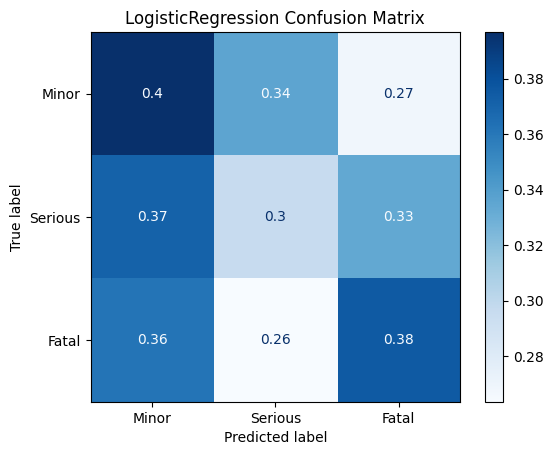

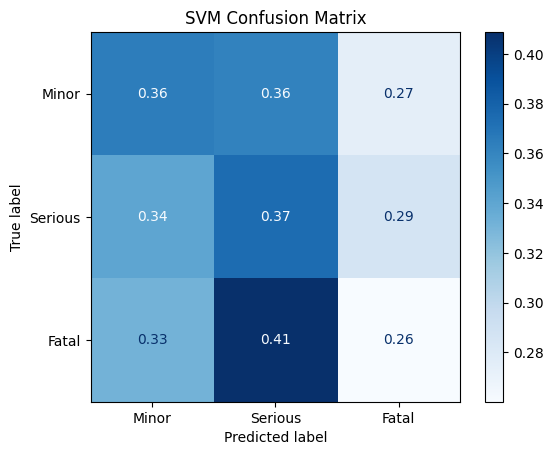

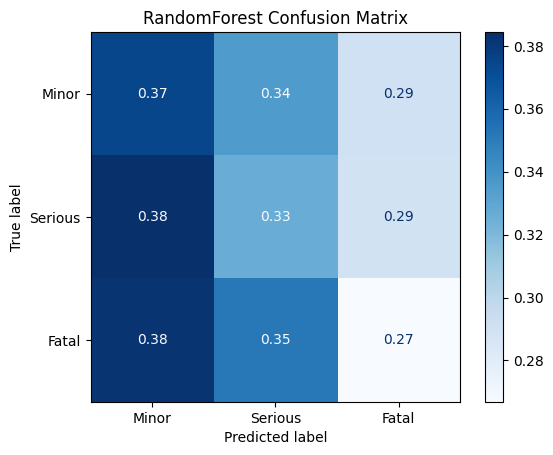

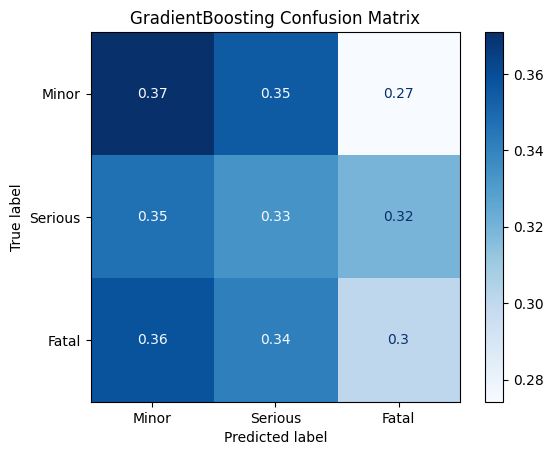

f:\Software\Anaconda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


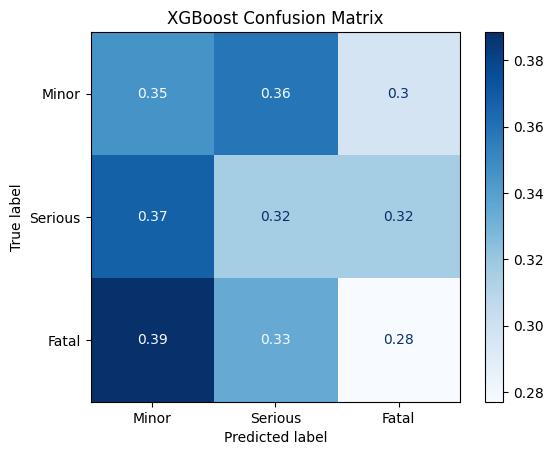

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 2100, number of used features: 34
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


f:\Software\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
f:\Software\Anaconda\envs\tf\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


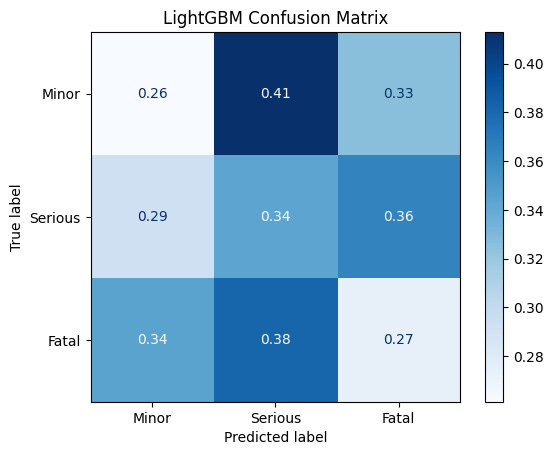

In [63]:
# Confusion Matrix
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    disp = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, display_labels=['Minor','Serious','Fatal'],
                                                 cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title(f'{name} Confusion Matrix')
    plt.show()

**Hasil**
- Kesalahan klasifikasi paling sering terjadi antara kelas Minor ↔ Serious dan Serious ↔ Fatal.
- Tidak ada satu kelas yang secara signifikan lebih sering diprediksi salah dibanding kelas lain (tidak bias kelas).

### 6.3 Feature Importance

**Fungsi Kode**:  
Kode ini bertujuan untuk menghitung dan memvisualisasikan tingkat kepentingan (importance) setiap fitur dalam model klasifikasi berbasis pohon keputusan. Fitur yang lebih penting memiliki kontribusi yang lebih besar terhadap prediksi model.

**Langkah-langkah**:
1. **Iterasi Model**:
    - Melakukan iterasi pada setiap model dalam dictionary `models`.
    - Mengecek apakah model memiliki atribut `feature_importances_` (hanya tersedia pada model berbasis pohon keputusan, seperti Random Forest, Gradient Boosting, XGBoost, dan LightGBM).
2. **Pipeline**:
    - Membuat pipeline yang menggabungkan preprocessing data (`preprocessor`) dan model klasifikasi (`classifier`).
    - Pipeline dilatih menggunakan data latih (`X_train`, `y_train`).
3. **Mengambil Importance Fitur**:
    - Mengambil nilai `feature_importances_` dari model yang telah dilatih.
    - Menggabungkan nama fitur numerik dan fitur kategorikal (hasil dari one-hot encoding) untuk mendapatkan daftar lengkap nama fitur.
4. **Mengurutkan Importance**:
    - Mengurutkan fitur berdasarkan tingkat kepentingannya secara menurun.
5. **Visualisasi**:
    - Membuat bar chart untuk menampilkan tingkat kepentingan setiap fitur.
    - Fitur dengan tingkat kepentingan tertinggi ditampilkan di bagian kiri grafik.

**Keuntungan**:
- Memberikan wawasan tentang fitur mana yang paling berpengaruh terhadap prediksi model.
- Membantu dalam proses feature selection dengan mengidentifikasi fitur yang kurang penting.
- Mempermudah interpretasi model berbasis pohon keputusan.

**Hasil**:
- Grafik bar chart menunjukkan tingkat kepentingan setiap fitur.
- Fitur numerik seperti `Speed Limit (km/h)` dan `Driver Age` sering kali memiliki tingkat kepentingan yang tinggi.
- Fitur kategorikal tertentu, seperti `Road Condition` atau `Weather Conditions`, juga dapat memberikan kontribusi signifikan.

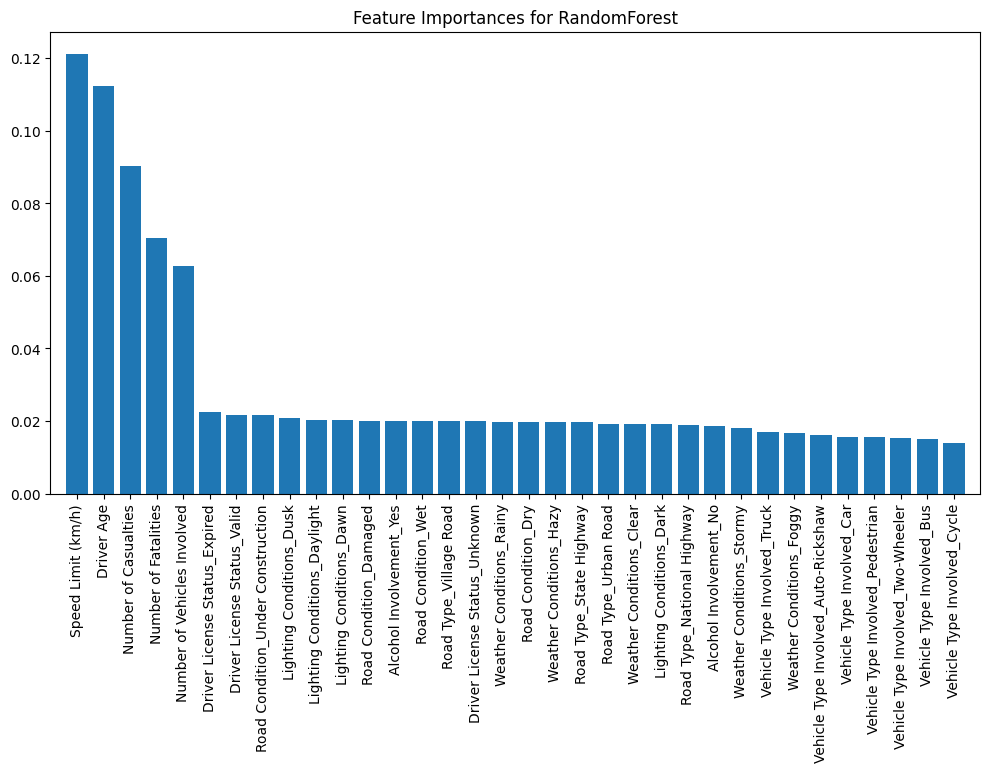

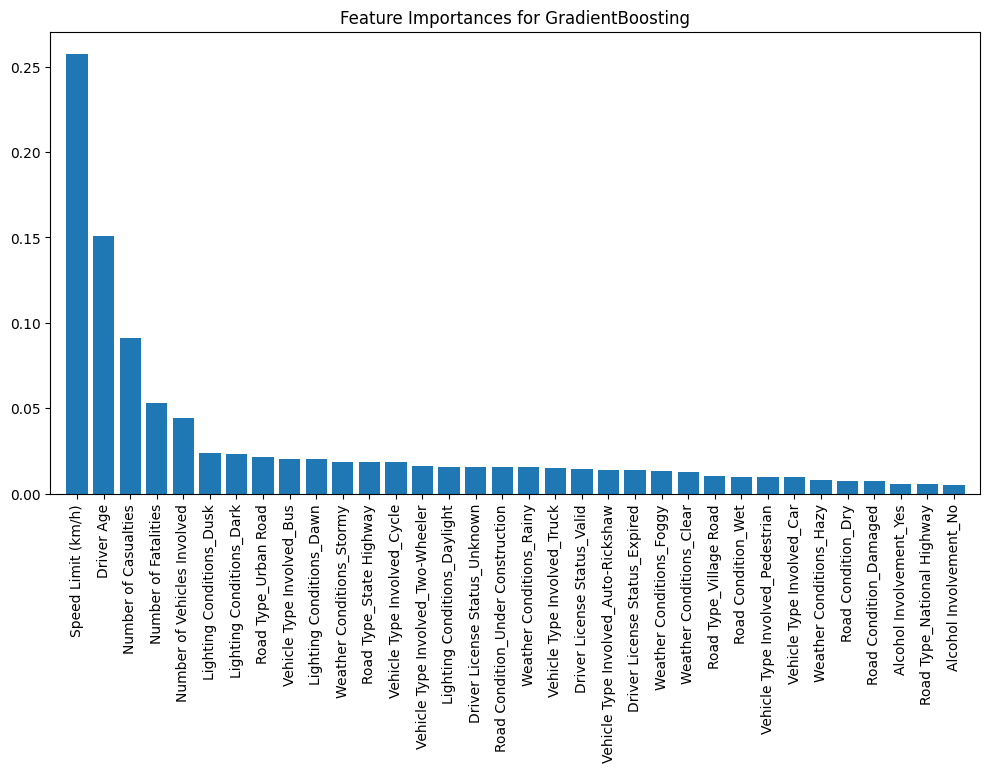

f:\Software\Anaconda\envs\tf\lib\site-packages\xgboost\core.py:158: UserWarning: [10:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


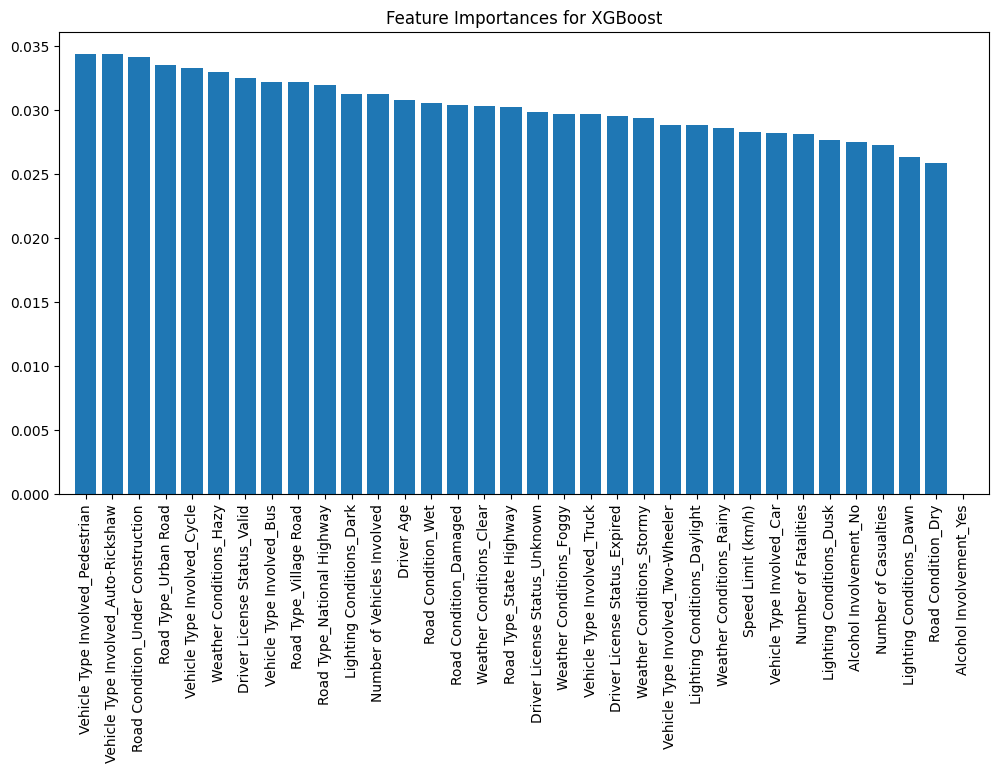

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 2100, number of used features: 34
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


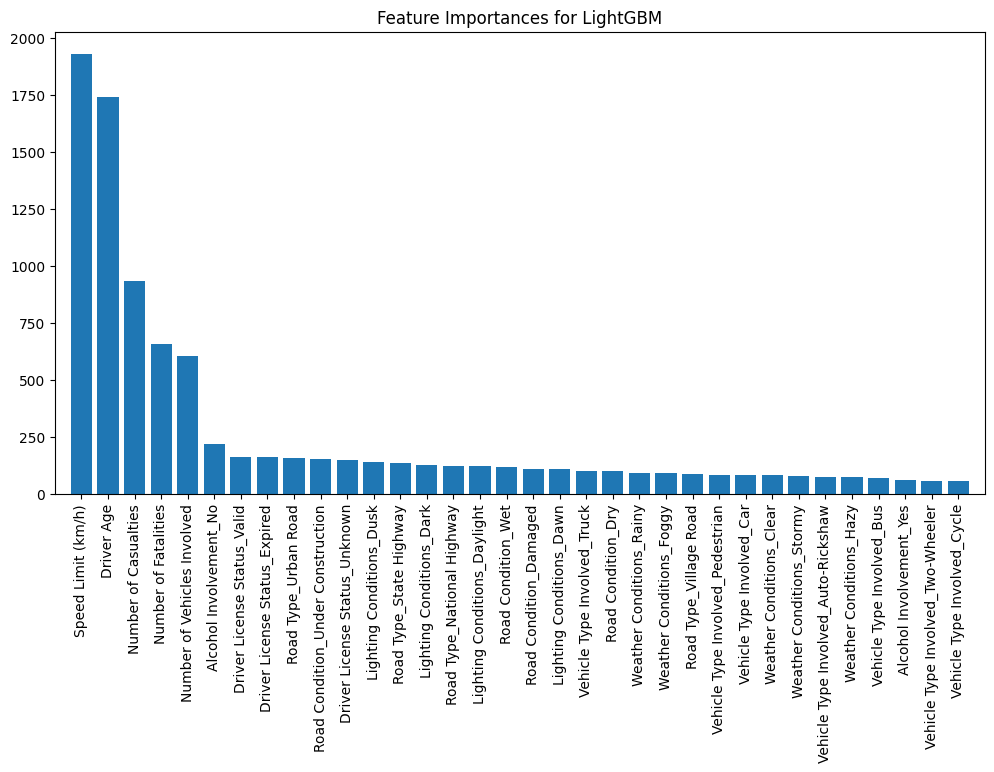

In [64]:
# Feature Importance
for name, clf in models.items():
    if hasattr(clf, 'feature_importances_'):
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])
        pipe.fit(X_train, y_train)
        importances = pipe.named_steps['classifier'].feature_importances_
        feature_names = numeric_features + list(pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importances for {name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.show()

## 7 Conclusion
### 7.1 Ringkasan Hasil  
- **Akurasi terbaik** pada test set hanya **~36%** (Logistic Regression & Gradient Boosting), sedangkan model tree‐based lain berkisar 29–33%.  
- **Performansi** semua model masih jauh di bawah target 75%, menunjukkan bahwa pola keparahan kecelakaan belum tertangkap dengan baik oleh fitur saat ini.  
- **Confusion Matrix** memperlihatkan banyak salah klasifikasi antar kelas Minor, Serious, dan Fatal—tanpa bias ke satu kelas tertentu.
### 7.2 Insight dari Feature Importance
- Speed Limit (km/h) dan Driver Age konsisten menjadi dua fitur paling berpengaruh di hampir semua model.
- Number of Casualties juga memiliki bobot tinggi, menandakan kecelakaan dengan banyak korban luka cenderung lebih parah.
- Fitur kategorikal seperti Road Condition (Under Construction, Damaged), Vehicle Type (Pedestrian, Auto‑Rickshaw), dan Weather Conditions (Stormy, Foggy) memberikan kontribusi menengah.
- Distribusi pentingnya fitur di XGBoost lebih merata, sedangkan Random Forest dan Gradient Boosting menitikberatkan pada beberapa variabel utama.
### 7.3 Business Decisions
- Penegakan Batas Kecepatan
- **Edukasi & Pelatihan Pengemudi** Program pelatihan khusus untuk kelompok usia muda (< 25 tahun) dan senior (> 60 tahun), yang menunjukkan risiko lebih tinggi.
- **Peningkatan Infrastruktur Jalan** Fokus pada perbaikan jalan rusak dan konstruksi; tambahkan rambu, marka jalan, dan penerangan di lokasi rawan.